In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import patsy
from xgboost import XGBRegressor
import seaborn as sns

In [2]:
def load_data(classes=['age', 'sex', 'weight', 'height']):
    path = './ptb-xl/'
    dataset = pd.read_json(path+'updated_ptbxl_database.json')
    dataset = dataset[classes + ['ABNORM']].dropna()

    test_split = int(0.8 * len(dataset))
    X = dataset[classes]
    y = dataset[['ABNORM']]

    train_df = pd.concat([X.iloc[:test_split], y.iloc[:test_split]], axis=1).dropna()
    test_df = pd.concat([X.iloc[test_split:], y.iloc[test_split:]], axis=1).dropna()

    train_data, train_labels = train_df[classes], train_df['ABNORM'].to_numpy()
    test_data, test_labels = test_df[classes], test_df['ABNORM'].to_numpy()

    return train_data, train_labels, test_data, test_labels

In [3]:
def logistic_regression(train_data, train_labels, test_data, test_labels, type='l1', data_string=""):
    coefs = []
    accuracies = []

    lambda_values = np.logspace(-1, 1, num=10)  # Generates 10 values logarithmically spaced between 10^-1 and 10^8

    for C in lambda_values:
        fit = LogisticRegression(penalty=type, solver='saga', warm_start=True, C=C, max_iter=10000).fit(train_data, train_labels)

        prediction_labels = fit.predict(test_data)
        accuracy = accuracy_score(test_labels, prediction_labels)

        coefs.append(C)
        accuracies.append(accuracy)
        
    plt.figure(figsize=(4, 4))
    plt.plot(coefs, accuracies)
    plt.title(f'{type} Logistic Regression Classifier: {data_string}')
    plt.xlabel('C')
    plt.ylabel('Classification Accuracy')
    plt.show()

In [4]:
def random_forests(train_data, train_labels, test_data, test_labels, data_string=""): 
    depths = []
    accuracies = []

    for depth in range(2, 15):

        fit = RandomForestClassifier(n_estimators=500, max_depth=depth).fit(train_data, train_labels)

        prediction_labels = fit.predict(test_data)
        accuracy = accuracy_score(test_labels, prediction_labels)

        depths.append(depth)
        accuracies.append(round(accuracy, 2))

    plt.figure(figsize=(4, 4))
    plt.plot(depths, accuracies)
    plt.title(f'Random Forests Classifier: {data_string}')
    plt.xlabel('Depth')
    plt.ylabel('Classification Accuracy')
    plt.show()

In [5]:
def xg_boost(train_data, train_labels, test_data, test_labels, data_string=''):
    depths = []
    accuracies = []

    for depth in range(2, 15):

        model = XGBRegressor(n_estimators=500, max_depth=depth, learning_rate=0.01, objective='reg:squarederror')
        model.fit(train_data.to_numpy().astype(np.float32), train_labels)

        prediction_labels = model.predict(test_data.to_numpy().astype(np.float32))
        threshold = 0.5
        prediction_labels = np.where(prediction_labels - np.floor(prediction_labels) >= threshold, np.ceil(prediction_labels), np.floor(prediction_labels)).astype(int)
        accuracy = accuracy_score(test_labels, prediction_labels)

        depths.append(depth)
        accuracies.append(accuracy)

    plt.figure(figsize=(4, 4))
    plt.plot(depths, accuracies)
    plt.title(f'XGBoost Classifier: {data_string}')
    plt.xlabel('Depth')
    plt.ylabel('Classification Accuracy')
    plt.show()

## Strategy - Try all combinations of each category
Types of data:
- weight, height
- age, weight, height
- sex, age, weight
- height, sex, age, weight

Models:
- l1 logistic regression
- l2 logistic regression
- Random Forests
- XGBoost

Representations:
- Basic
- Interaction

# Weight, Height

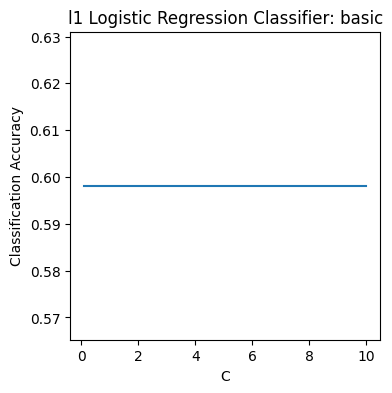

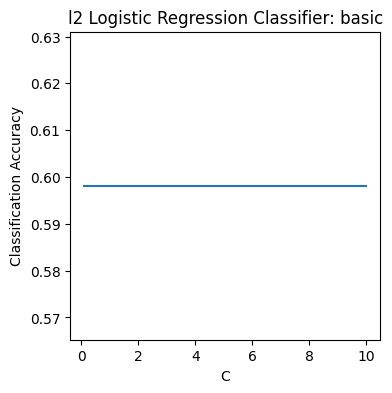

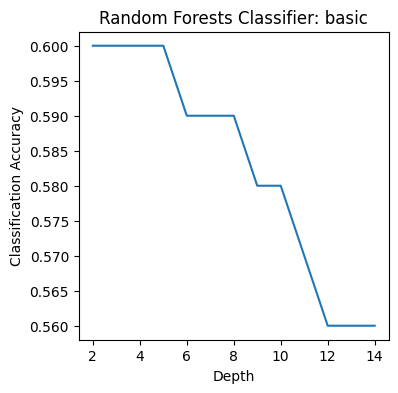

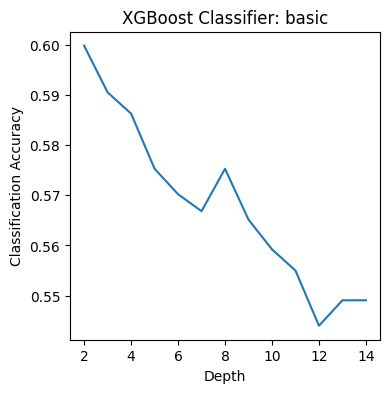

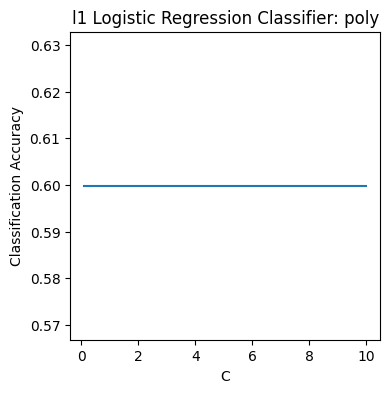

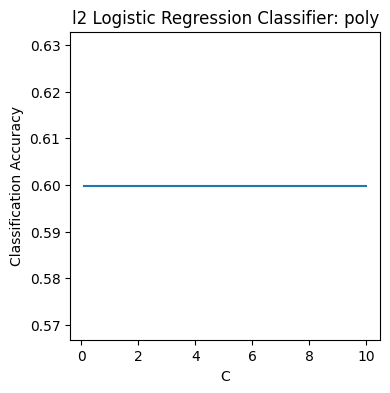

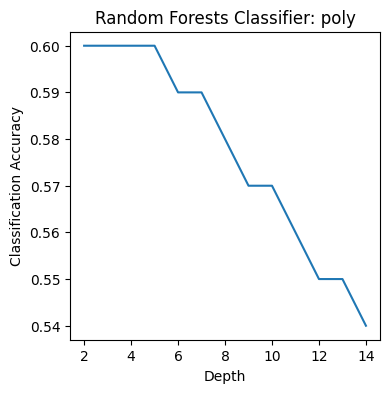

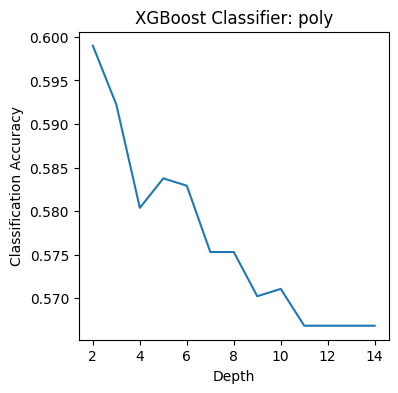

In [33]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['weight', 'height'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'height:weight'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Weight Age

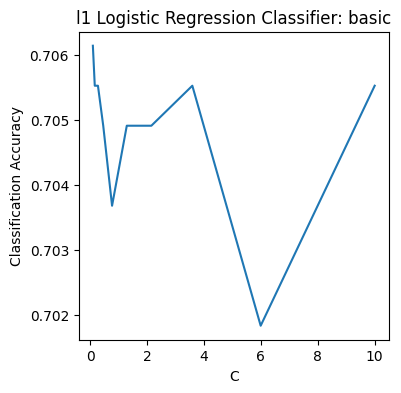

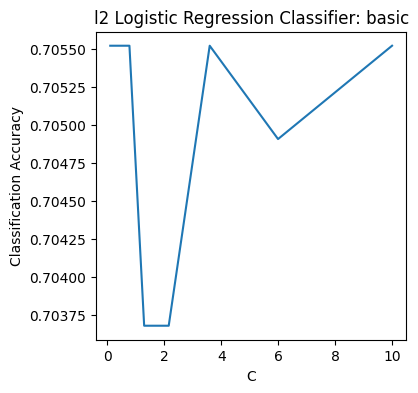

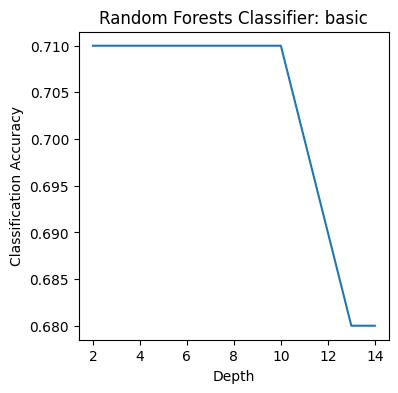

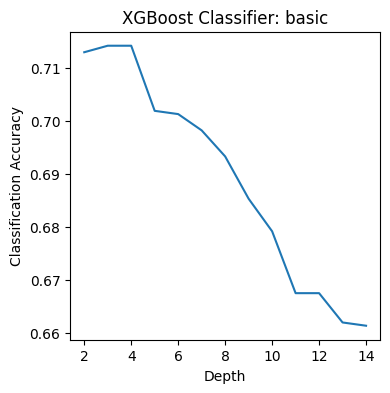

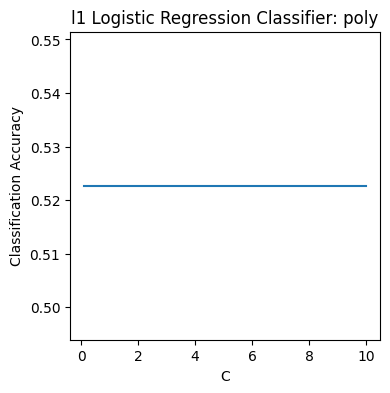

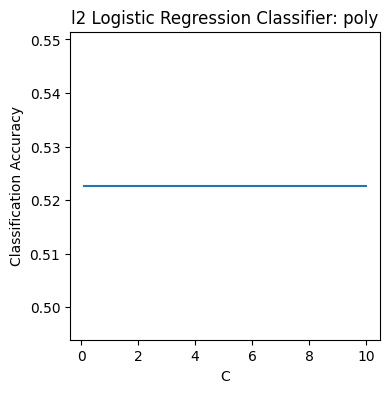

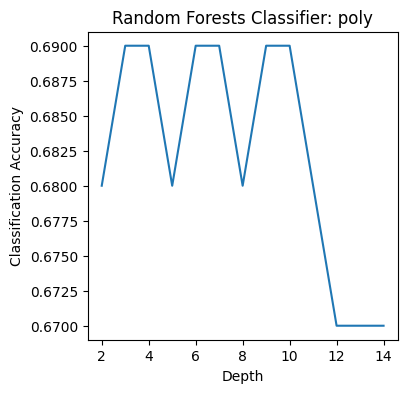

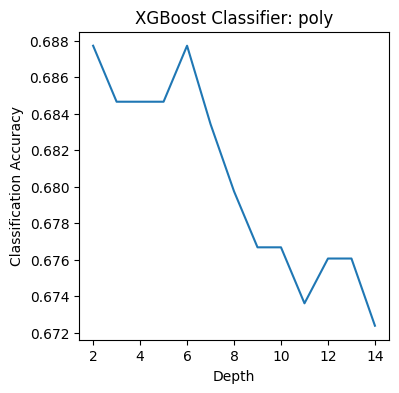

In [6]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['weight', 'age'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'age:weight'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Age, Weight, Height

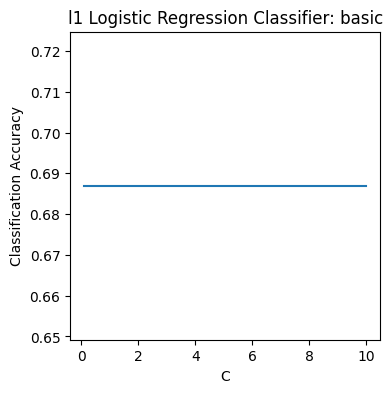

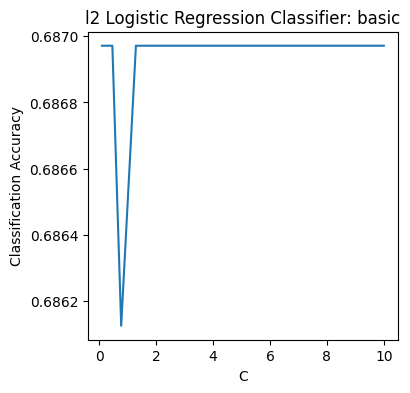

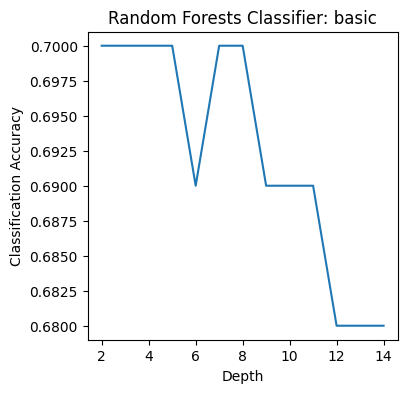

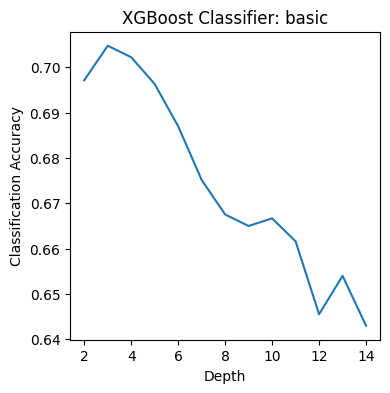

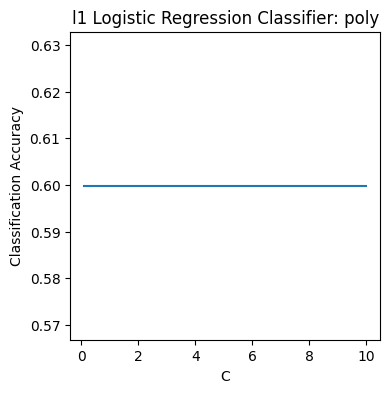

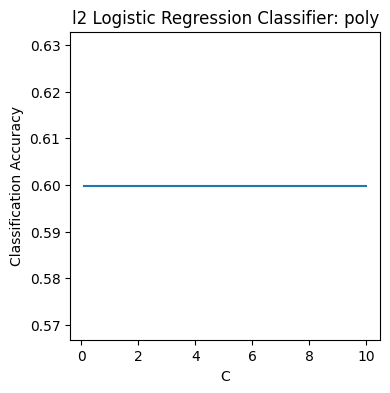

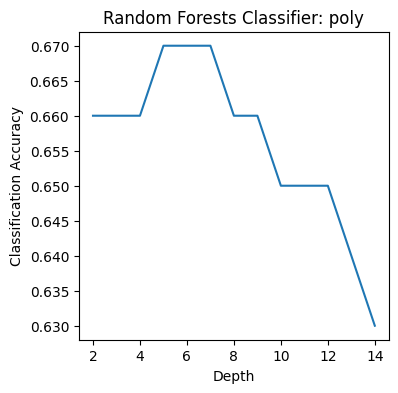

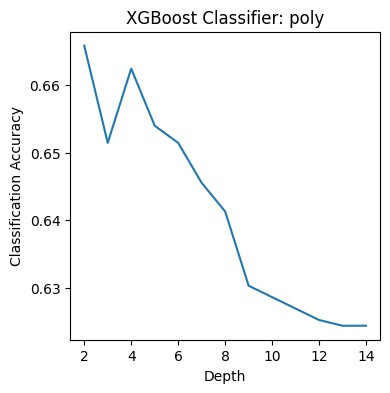

In [32]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['age', 'weight', 'height'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'height:weight:age'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Weight, Age, Sex

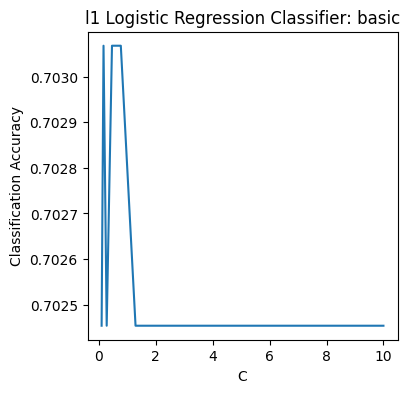

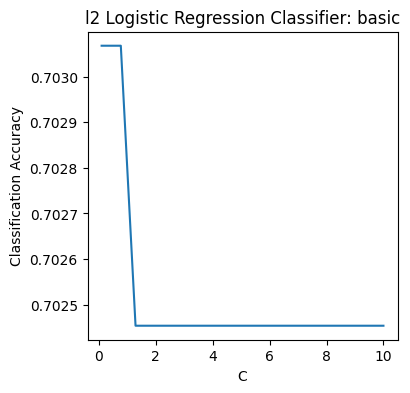

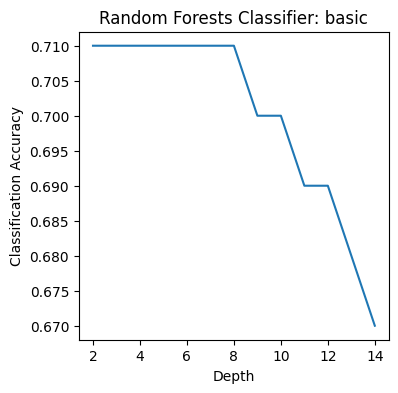

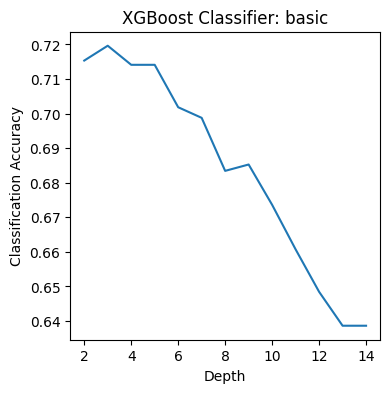

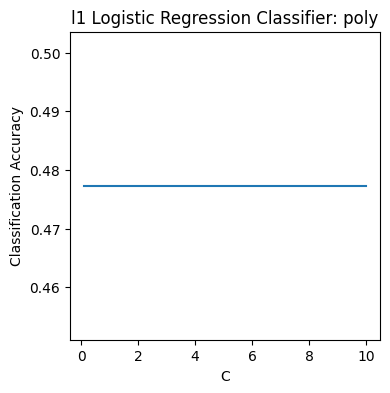

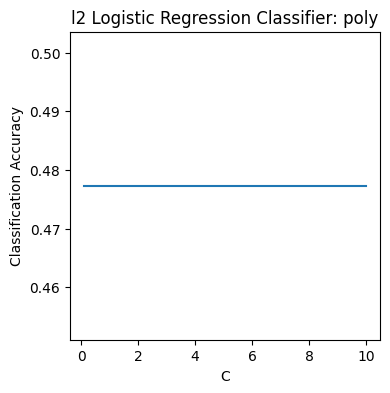

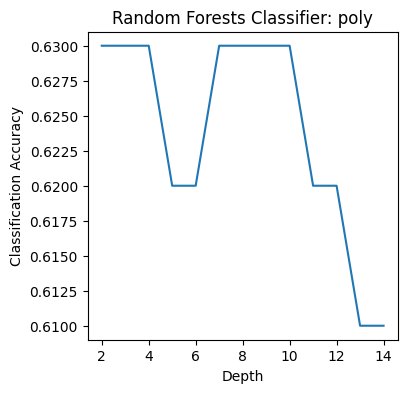

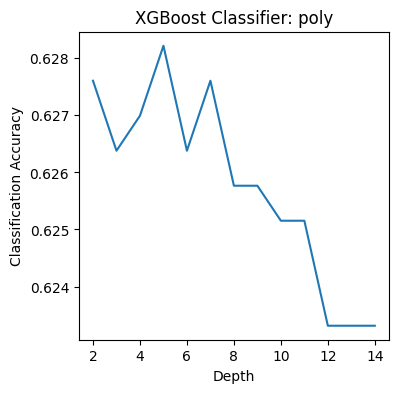

In [29]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['age', 'sex', 'weight'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'age:weight:sex'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Height, Weight, Age, Sex

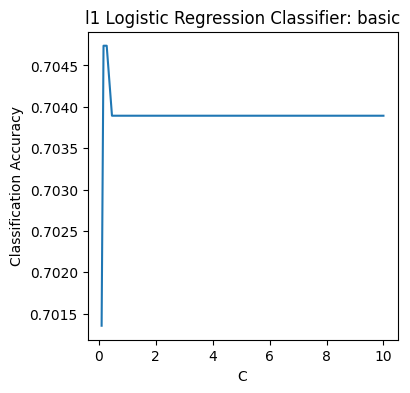

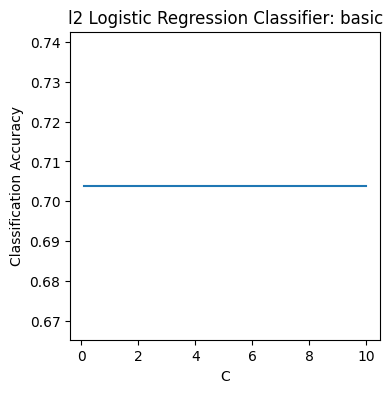

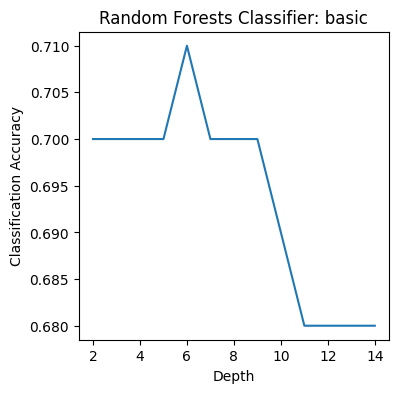

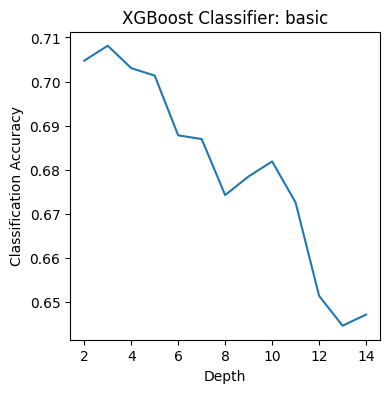

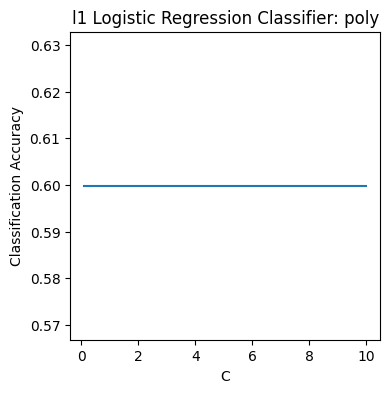

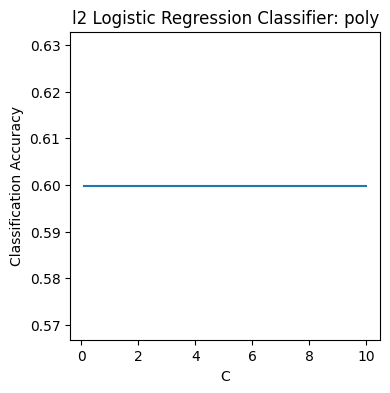

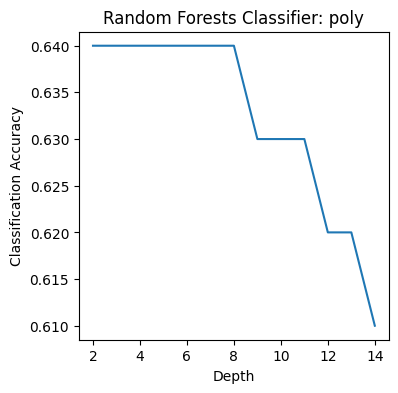

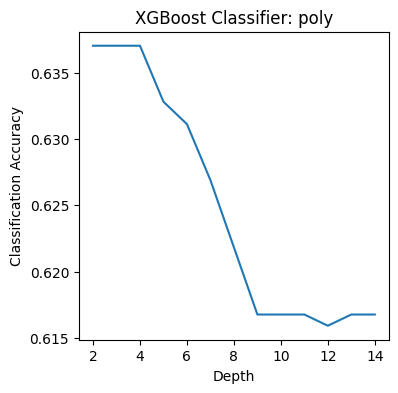

In [30]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['age', 'sex', 'weight', 'height'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'age:weight:sex:height'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

In [7]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Load the data
train_data, train_labels, test_data, test_labels = load_data(['age', 'sex', 'weight'])

# Train the XGBoost model
model = XGBRegressor(n_estimators=500, max_depth=3, learning_rate=0.01, objective='reg:squarederror')
model.fit(train_data.to_numpy().astype(np.float32), train_labels)

# Make predictions
prediction_labels = model.predict(test_data.to_numpy().astype(np.float32))
threshold = 0.5
prediction_labels = np.where(prediction_labels - np.floor(prediction_labels) >= threshold, np.ceil(prediction_labels), np.floor(prediction_labels)).astype(int)


Confusion Matrix:
[[555 224]
 [233 618]]
F1 Score: 0.7300649734199646
Precision: 0.7339667458432304
Recall: 0.7262044653349001


Confusion Matrix:
[[555 224]
 [233 618]]
F1 Score: 0.7300649734199646
Precision: 0.7339667458432304
Recall: 0.7262044653349001


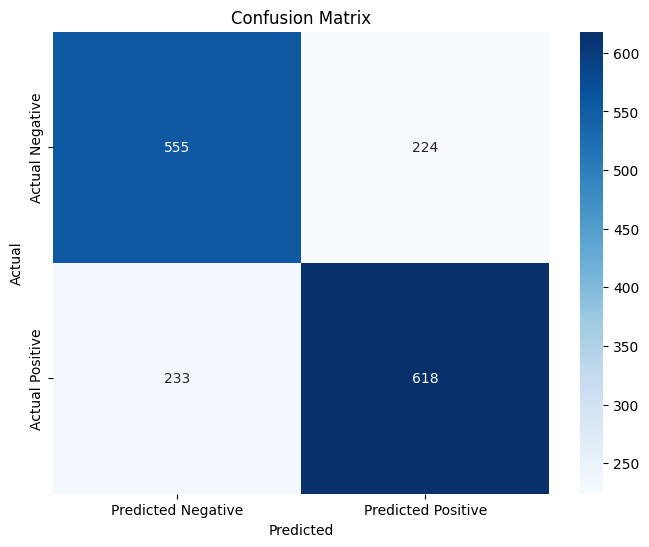

In [8]:
# Calculate metrics
conf_matrix = confusion_matrix(test_labels, prediction_labels)
f1 = f1_score(test_labels, prediction_labels)
precision = precision_score(test_labels, prediction_labels)
recall = recall_score(test_labels, prediction_labels)

print("Confusion Matrix:")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1]:
total = 555 + 224 + 233 + 618
FN = 233

FNR = FN / total

print(f"False Negative Rate: {FN / total}")
print(f"True Positive Rate: {1 - FNR}")     

False Negative Rate: 0.14294478527607363
True Positive Rate: 0.8570552147239263
